# Going further
----------------------

In this notebook, we show a few examples where the simplicity of the interface and additional helper functions can come in handy.

## Interchangibility of the descriptors
-----------------------------------------------

Say we performed a clustering on a system using a given structural descriptor, *e.g.* using bond angles:

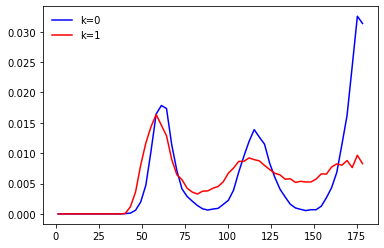

In [1]:
from pysc import Trajectory, Workflow
from pysc.descriptor import BondAngleDescriptor
import matplotlib.pyplot as plt

# trajectory
traj = Trajectory('../data/wahn_N1000.xyz')

# bond-angle descriptor
D_ba = BondAngleDescriptor(traj)
D_ba.add_filter("species == 'B'")

# optimization
wf = Workflow(traj,
              descriptor=D_ba,
              scaling='zscore',
              clustering='kmeans')
wf.clustering.n_init = 100
wf.run()

# plot the centroids
theta = D_ba.grid
Ck = wf.clustering.centroids(wf.features)
norm = D_ba.normalize_sin
plt.plot(theta, norm(Ck[0]), c='b', label='k=0')
plt.plot(theta, norm(Ck[1]), c='r', label='k=1')
plt.legend(frameon=False)
plt.show()

We are now curious to see the $g(r)$ of the clusters, despite the fact that the clustering was performed using bond angles.

We only need to compute the radial descriptor, and then we can directly use the labels of the previous clustering to look at the corresponding radial distributions: 

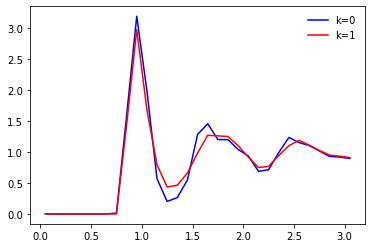

In [2]:
from pysc.descriptor import RadialDescriptor

# compute the radial descriptor
D_r = RadialDescriptor(traj)
D_r.add_filter("species == 'B'")
X_r = D_r.compute()

# plot the corresponding radial centroids
# using an external dataset for the centroids
r = D_r.grid
gk = wf.clustering.centroids(X_r)
norm = D_r.normalize_gr
plt.plot(r, norm(gk[0]), c='b', label='k=0')
plt.plot(r, norm(gk[1]), c='r', label='k=1')
plt.legend(frameon=False)
plt.show()

The result of clustering performed using any arbitrary descriptor can thus be visualized using any other dataset (including datatsets on which feature scaling or dimensionality reduction were performed).

## Identification of structural heterogeneity without clustering
-----------------------------------------------------------------------------

The `Workflow` class is useful when we already know the exact worflow to follow when using a clustering. However, when studying the local structure of a system in a broader context, some aspects can become apparent without the need for a clustering.

Here, we compute the bond orientational descriptor of a system and look at the feature space in reduced dimension:

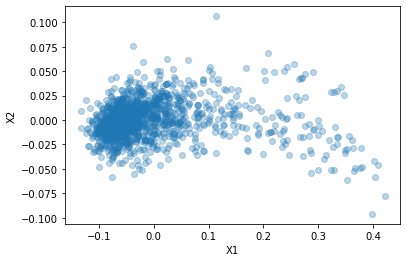

In [3]:
from pysc.descriptor import LechnerDellagoDescriptor
from pysc import PCA

# open trajectory
traj = Trajectory('../data/kalj_fcc_N1200.xyz')

# compute descriptor
D_ld = LechnerDellagoDescriptor(traj)
X = D_ld.compute()

# dimensionality reduction
redux = PCA(n_components=2)
X_red = redux.reduce(X)

# show reduced feature space
plt.scatter(X_red[:,0], X_red[:,1], alpha=0.3)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

We see in the reduced feature space that the majority of the particles is concentred on the left, while some outliers are present on the right. Without even the need for a clustering, we want to see how different these particles are from the bulk. For that, we decide that each particle with reduced feature $X_1 > 0.18$ is somehow *special*.

Let us give this binary attribute `special` to all the particles: 0 if not special, 1 if special:

In [4]:
# Select outliers based on their first reduced feature
threshold = 0.18
outliers = []
for xn, x in enumerate(X_red):
    if x[0] > threshold:
        outliers.append(xn)

# Set a particle property `special` to 0 or 1
# by iterating over the group 0 of the descriptor
# (i.e.) all the particles for which the descriptor was computed
traj[0].set_property('special', 0)
for pn, p in enumerate(D_ld.groups[0][0]):
    if pn in outliers:
        p.special = 1

In order to see these particles in a snapshot, let us set a very small value for the `radius` of all the particles that are not special, and a regular radius for the special ones:

In [5]:
traj[0].set_property('radius', 0.05, 'particle.special == 0')
traj[0].set_property('radius', 0.5, 'particle.special == 1')

ValueError: attribute "special" is not recognized

We can visualize the particles in real space to see why these outliers stand out:

In [ ]:
fig = traj[0].show(color='special', view='back', show=True)
fig = traj[0].show(color='special', view='right', show=True)
fig = traj[0].show(color='special', view='left', show=True)

It turns out that the outliers form a small FCC crystal. We were able to see that something was different in their local structure solely based on their position in the reduced feature space. 

## Aggregation of clusters
---------------------------------

When performing a clustering with model-based methods, such as the *Gaussian Mixture Model* (GMM) that consists in fitting a given number of multivariate Gaussian distributions to the data, it can happen that the original distribution is poorly fitted by the by various components. Or we could be unsure about the right number of components to use to fit the original distribution.

Let's come back to the previous example, on which we will perform a clustering using GMM with more components than needed:

In [ ]:
from pysc import GaussianMixture
import numpy as np

# Perform a clustering on the reduced feature space
# of the previous example
C = GaussianMixture(n_clusters=4, n_init=50)
C.fit(X_red)
labels = C.labels

# Plot the clusters in reduced feature space using
# a *hard* clustering
clrs = np.array(['r', 'b', 'g', 'y'])
plt.scatter(X_red[:,0], X_red[:,1], c=clrs[labels], alpha=0.3)
plt.show()

Here, we are basically cutting slices through a distribution that could be approximated well enough with only two Gaussians.

Let us use an aggregation method (see [Baudry et al., 2010](https://doi.org/10.1198/jcgs.2010.08111)) to merge these 4 clusters into 2 by combining the components of GMM:

In [ ]:
from pysc.helpers import merge_clusters

# Use weights from GMM to merge the clusters into `n_cluster_min`
# this returns new weights and new labels
weights = C.backend.predict_proba(X_red)
new_weights, new_labels = merge_clusters(weights, n_clusters_min=2)

# Plot clusters with new labels
plt.scatter(X_red[:,0], X_red[:,1], c=clrs[new_labels], alpha=0.3)
plt.show()

The old clusters were merged into 2 new clusters that form a better partitioning.